# Forecasting from ERA5 reanalysis Data



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr

import TensorDynamics.model_def as model_def

from TensorDynamics.preprocess import preprocess_data
import tensorflow as tf
tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


We create a model with 20 equidistant sigma levels, a truncation of 83, and 128 gaussian latitudes. The model will be run for 72 hours (3 days)

In [8]:

# model input parameters
nlevels=20
trunc=np.int32(85)
nlats=128

# create the model
model=model_def.model(nlats,trunc,nlevels,int_type="leap",do_physics=True)

# runtime of the forecast in hours
days=3
runtime=24*days # hours


We will download data from the forecast initialization data to the forecast end date with one day intervals. Since the data is on 37 pressure levels and a regular 0.25 degree grid, we will need to preprocess onto the model grid.

Requires installation of zarr and gcsfs python packages.
Data website: https://cloud.google.com/storage/docs/public-datasets/era5

In [9]:
# set initial date
start_date="2022-01-01"
#all_dates=[np.datetime64(start_date)+np.timedelta64(i,"D") for i in range(days+1)]
all_dates=[np.datetime64(start_date),np.datetime64(start_date)+np.timedelta64(days,"D")]

# list of needed variables to start the model
model_vars=["u_component_of_wind","v_component_of_wind","geopotential_at_surface","surface_pressure","temperature","specific_humidity"]

# download the data
data = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)[model_vars].sel(time=all_dates)

# preprocess data, list of dictionaries, which each contain the atmospheric data at one day intervals
states=preprocess_data(model,data)

# grab the dictionaries for the initial state, and the final state (for plotting later)
init_state=states[0]
end_state=states[-1]

sh = init_state["specific_humidity"]

Run the model for the chosen runtime and initial atmospheric state

In [10]:
# To run without humidity, could set initial state to zero humidity
init_state["specific_humidity"]=sh

print("Internal model timestep (minutes): ", model.dt/60)
model_end_state=model.stepper(runtime,init_state)



Internal model timestep (minutes):  15.0


## Comparison with Reanalysis

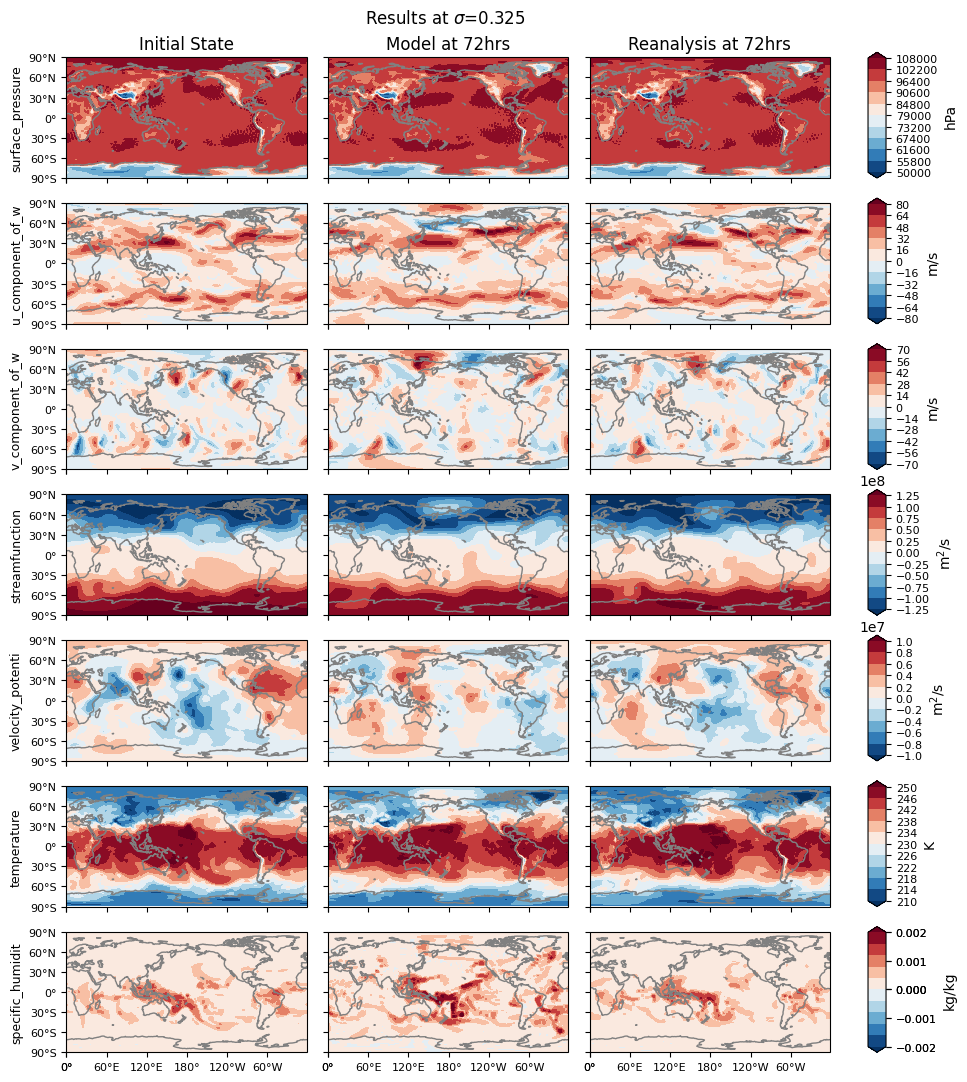

In [16]:
# get lats and lons
lats=model.f_obj.lats
lons=model.f_obj.lons

# choose which sigma level to plot
plot_ind=6

# create matplotlib figure
cl=180
fig=plt.figure(figsize=[9,11])
proj = ccrs.PlateCarree(central_longitude=cl)

# columns will be separate times or models
titles=["Initial State","Model at " +str(runtime)+"hrs","Reanalysis at " +str(runtime)+"hrs"]
plot_states=[init_state,model_end_state,end_state]

# rows will be different variables
plot_vars=["surface_pressure","u_component_of_wind","v_component_of_wind","streamfunction","velocity_potential","temperature","specific_humidity"]
mags=[1080,80,70,1.25e8,1e7,250,0.002] # magnitudes for contourf
units=["hPa","m/s","m/s",r"m$^2$/s",r"m$^2$/s","K","kg/kg"]

# empty list to store plot objects for making colorbars later
ims=[]
levels_list=[]



# loops over columns and rows to make subplots
for j, plot_state in enumerate(plot_states):

	plot_state=model.decode(model.encode(plot_state)) # use decode to make sure we have streamfunction and velocity potential

	for i,varname in enumerate(plot_vars):
		ax=plt.subplot(len(plot_vars),len(plot_states),3*i+j+1,projection=proj)

		# grab data at correct level
		if varname=="surface_pressure":
			field=plot_state[varname][0]
		else:
			field=plot_state[varname][plot_ind]
		

		# create levels for contour f
		mag=mags[i]
		levels=np.linspace(-mag,mag,num=11)
		if varname=="surface_pressure":
			levels=np.linspace(500*100,1080*100,num=11)
		elif varname=="temperature":
			levels=np.linspace(210,250,num=11)

		im=ax.contourf(lons*180/np.pi,lats*180/np.pi,field,levels=levels,transform=ccrs.PlateCarree(),cmap="RdBu_r",extend='both')
		
		# formatting
		ax.coastlines(color="gray")
		lon_formatter = LongitudeFormatter()
		lat_formatter = LatitudeFormatter()
		ax.xaxis.set_major_formatter(lon_formatter)
		ax.yaxis.set_major_formatter(lat_formatter)
		ax.tick_params(labelsize=8)
		ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
		ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
		
		if i<len(plot_vars)-1:
			ax.tick_params(labelbottom=False) 
		if j>0:
			ax.tick_params(labelleft=False) 

		# set titles/ylabels
		if i==0:
			ax.set_title(titles[j])
		if j==0:
			ax.set_ylabel(varname[0:16],size=9)
		
		# append image objects and levels for making colorbars
		if j==0:
			ims.append(im)
			levels_list.append(levels)

plt.suptitle(r"Results at $\sigma$="+str(model.sigmas[plot_ind].numpy()))

num_cbars=len(plot_vars)

# Create blank space to add a colorbar for each row
cbar_right=0.95
fig.subplots_adjust(right=cbar_right-0.01)
plt.tight_layout(rect=[0,0,cbar_right,1])

# Create colorbars
for i,image in enumerate(ims):
	pos=plt.subplot(len(plot_vars),len(plot_states),3*i+0+1,projection=proj).get_position().get_points()
	cbar_ax = fig.add_axes([cbar_right+.02,pos[0][1], 0.02, 0.8/num_cbars])
	
	label=units[i]
	ticks=np.array([np.round(l,3) for l in levels_list[i]])
	
	cbar=fig.colorbar(image,orientation='vertical',ticks=ticks,label=label, cax=cbar_ax)
	
	cbar.ax.tick_params(labelsize=8) 
	cbar.set_label(label=label,size=10)



